# Uplift modeling

In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

Let's suppose we as a comapny find an action to prevent churn. I will simulate how customers will respond, what kind of profits will come with this and how churn will change.
- Firstly i will fabricate dataset of customers after campaing
- Then i will uplift model 

### Dataset creation

Uderlying assumptions:
- there is a decrease in customer service callls
- There is bigger agrement renewal

In [95]:
data = pd.read_csv('data/telecom_churn.csv')

#### Cust service calls

Let's assume that our campaing decresed number of calls by 15 percent. 

In [96]:
data.CustServCalls.mean() , data.CustServCalls.mean() * 0.85 # mean calls is 1.5, 85% of that is 1.3 

(1.5628562856285628, 1.3284278427842784)

In [97]:
decresd_calls = data.CustServCalls *0.85 # decrease calls by one
decresd_calls.mean()

1.3284278427842784

### Renewal

In [98]:
contract_ren_1 = data[data['ContractRenewal'] == 1]
contract_ren_0 = data[data['ContractRenewal'] == 0]

In [99]:
3333 * 0.92 , 3333 - 3066 

(3066.36, 267)

In [100]:
s = 3333 # sample size

ratio = 0.92 # 92% renewal rate
ren =3066 # renewed customers
not_ren = 3333 - 3066 # non-renewed customers

ren_sample = contract_ren_1.sample(n =ren, random_state=42, replace = True) # sample 3066 customers from the renewed customers
not_ren_sample = contract_ren_0.sample(n =not_ren, random_state=42, replace = True) # sample 3066 customers from the non-renewed customers

print(ren_sample.shape, not_ren_sample.shape)

fabricated = pd.concat([ren_sample, not_ren_sample], axis=0) # concat the two samples

(3066, 11) (267, 11)


In [101]:
fabricated.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
958,0,91,1,1,3.32,3,232.4,97,89.2,9.30,12.3
1436,0,83,1,1,2.92,1,226.4,117,88.2,11.74,10.8
1256,0,98,1,0,0.00,2,162.8,65,44.0,9.25,6.0
1217,0,80,1,1,2.89,4,166.4,92,77.9,11.92,10.7
1817,0,116,1,0,0.00,2,167.8,119,41.0,7.10,7.3


## Uplift  with increased renewal rate

### One model aproach

In [102]:
data['campaing'] = 0 # original data
fabricated['campaing'] = 1 # fabricated data after supposed campiang increasing renewal rate

merged_data = pd.concat([data, fabricated], axis=0)
merged_data.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,campaing
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0,0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7,0
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2,0
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6,0
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1,0


In [103]:
# ct = ColumnTransformer([
#     ('binary data', OneHotEncoder(), [2,3]),
#     ('standard', StandardScaler(), [1,4,5,6,7,8,9,10])],
#     remainder = 'passthrough')

# merged_data =  ct.fit_transform(merged_data)

X_train, X_test, y_train, y_test = train_test_split(merged_data.iloc[:,1:],merged_data.Churn, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
X_train[:1]

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,campaing
556,123,1,0,0.0,0,159.5,77,53.0,15.19,12.0,1


In [104]:
treat_train = X_train['campaing']
cat_features = ['ContractRenewal','DataPlan']
treat_val = X_valid['campaing']

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [105]:
sm = SoloModel(XGBClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={})

[11:20:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "iterations", "silent", "thread_count" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [106]:
uplift_sm = sm.predict(X_valid)

sm_score = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

In [107]:
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

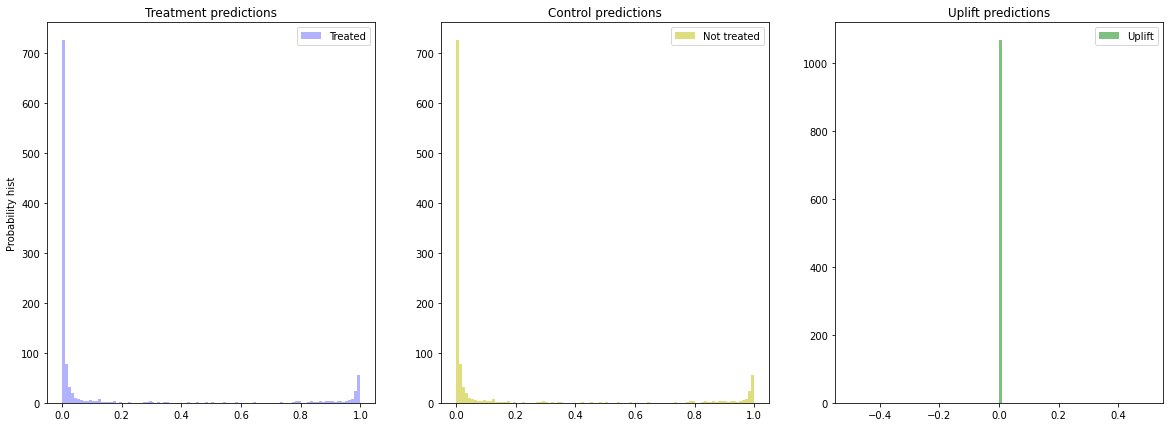

In [108]:
# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [109]:
# You can also access the trained model with the same ease.
# For example, to build the importance of features:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_in_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,DataPlan,0.452658
1,ContractRenewal,0.151081
2,CustServCalls,0.098196
3,DayMins,0.062068
4,MonthlyCharge,0.058307
5,DataUsage,0.050547
6,OverageFee,0.037652
7,RoamMins,0.032983
8,AccountWeeks,0.024253
9,DayCalls,0.022946


### Two model aproach

[11:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "iterations", "silent", "thread_count" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "iterations", "silent", "thread_count" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




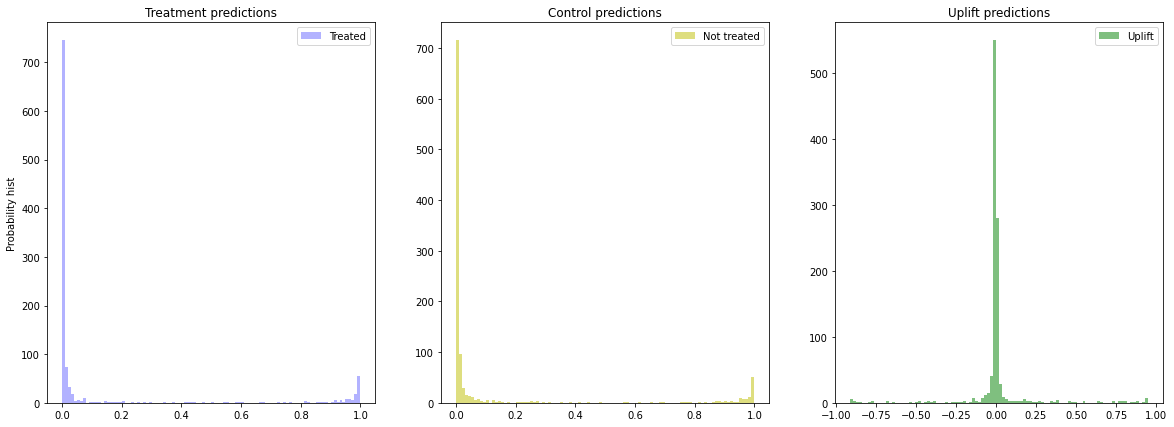

In [116]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=XGBClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=XGBClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_valid)

tm_score = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);